In [1]:
#This script will compute the mass convergence and divergence out of a cylinder around the TC center

import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import *
from pylab import *

import pyproj
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.geodesic import Geodesic
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import shutil

# Download state and coastline data
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from PIL import Image

#for color scale
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [2]:
#Set some constants for later use that we may or may not use, just there for any meteorological claculation you may conduct
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50
k          = 0.4          #Von Karmen Constant

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [6]:
#First, Specifiy File path
filepath_wrfout = '/glade/derecho/scratch/cmasiello/nest_following_version/WRFV4.5.2/test/em_real_Control/wrfout_d02*' 
datafiles_wrfout = sorted(glob.glob(filepath_wrfout))

In [7]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


In [8]:
#Vectorized Haversine function accepting degrees
def vectorized_haversine_deg(lon1, lat1, lon2, lat2):
    R = 6371000  # Radius of the Earth in meters
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

def trapezoidal_rule(y, x):
    return np.sum((x[1:] - x[:-1]) * (y[1:] + y[:-1]) / 2.0)

In [9]:
#Creating IR color Scale
def make_Ramp(ramp_colors):
    color_ramp = LinearSegmentedColormap.from_list('my_list', ramp_colors)
    plt.figure(figsize=(15, 3))
    plt.imshow([list(np.arange(0, len(ramp_colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp([
        "#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
        "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
        "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
        "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
        "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
        "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
        "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
        "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
        "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
        "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
        "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
        "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
        "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
        "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
        "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
        "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
        "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
        "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
        "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
        "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
        "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
        "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
        "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
        "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
        "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
        "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
        "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
        "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
        "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
        "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
        "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
        "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
        "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
        "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
        "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
        "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
        "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
        "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
        "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
        "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
        "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
        "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
        "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
        "#fffef1","#fffef4","#fffff6"])

top = custom_ramp
bottom = plt.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 66)), bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name='Cam_Cool_Color_Scale')

WRF valid time:  2007-08-24_18 2007-08-24 18:00 2007-08-24T18:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:145: RuntimeWarning: Mean of empty slice
  pvazavgNE[k,bincnt]  = np.nanmean(pvbinNE[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:146: RuntimeWarning: Mean of empty slice
  windzavgNE[k,bincnt] = np.nanmean(windbinNE[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:148: RuntimeWarning: Mean of empty slice
  pvazavgNW[k,bincnt]  = np.nanmean(pvbinNW[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:149: RuntimeWarning: Mean of empty slice
  windzavgNW[k,bincnt] = np.nanmean(windbinNW[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:151: RuntimeWarning: Mean of empty slice
  pvazavgSW[k,bincnt]  = np.nanmean(pvbinSW[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/3724787575.py:152: RuntimeWarning: Mean of empty slice
  windzavgSW[k,bincnt] = np.nanmean(windbinSW[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel

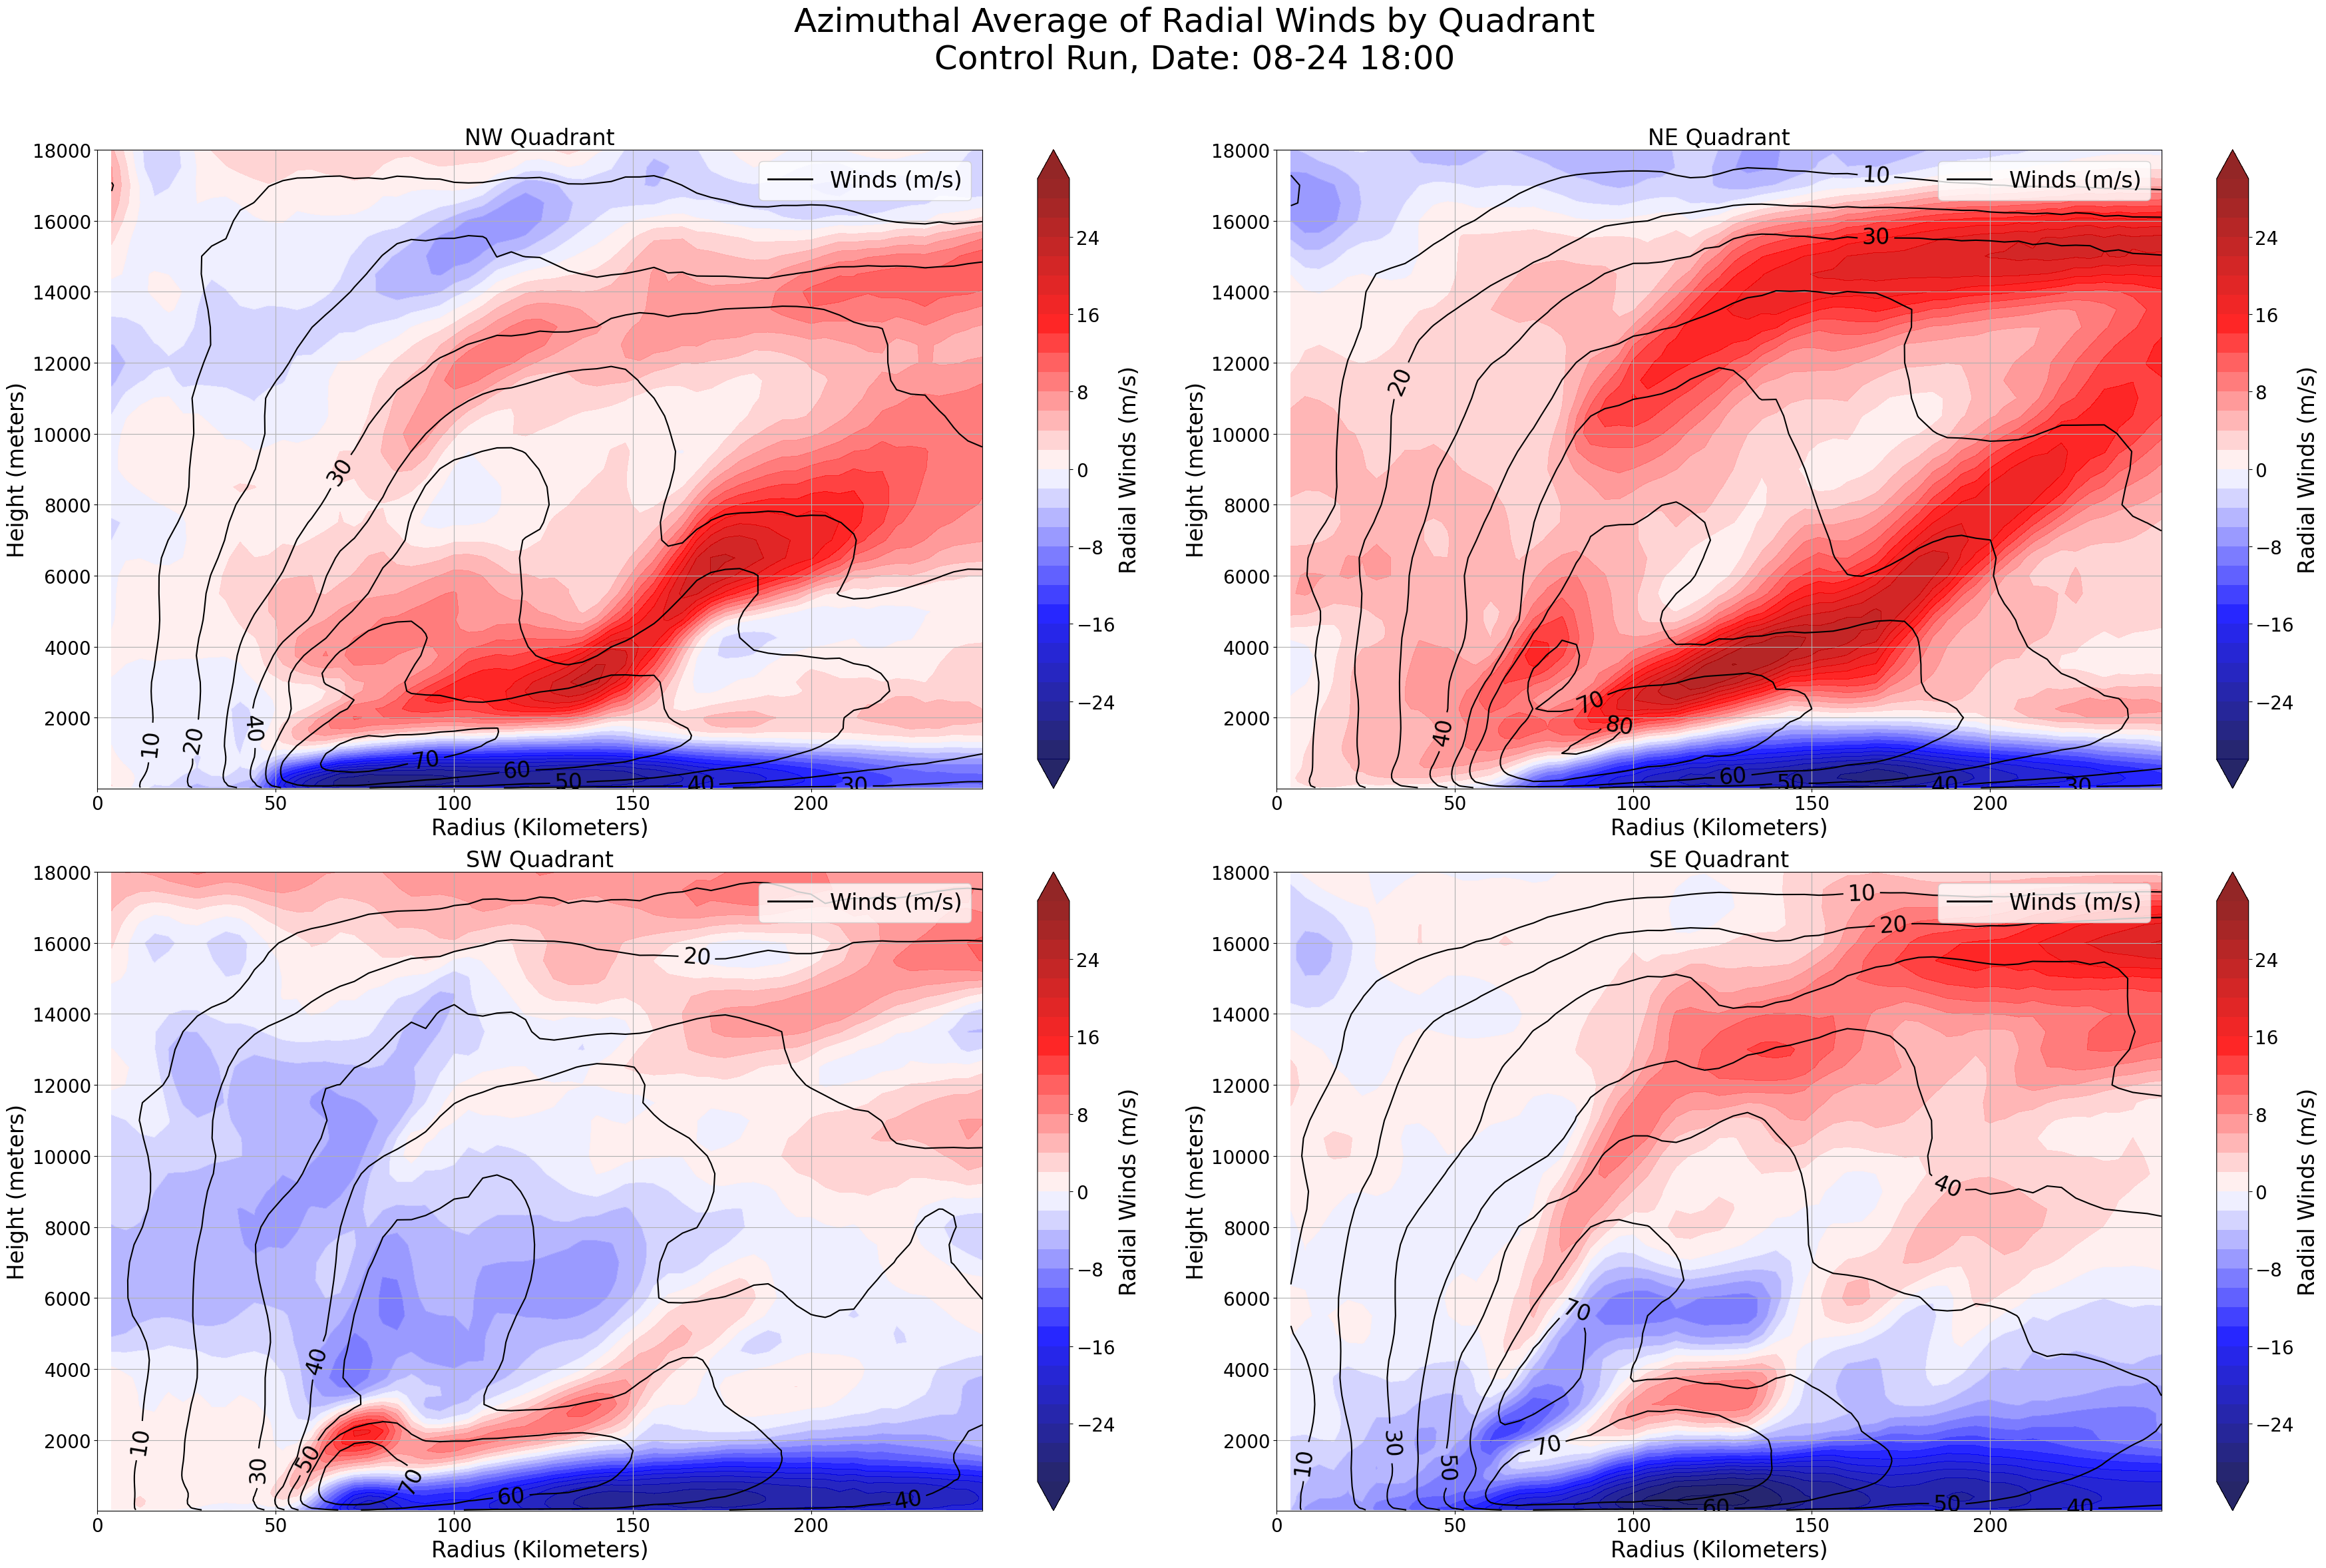

In [10]:
for item in range(54,55):
    ncfile = Dataset(datafiles_wrfout[item])
    wrf_out_data = xr.open_dataset(datafiles_wrfout[item])
    
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    
    #Get constant variables
    lat = getvar(ncfile, "XLAT")
    lon = getvar(ncfile, "XLONG")
    land = wrf_out_data['LANDMASK'][0,:,:].values
    ny, nx = lat.shape
    ###############################################################################################
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ##############################################################################################
    #IR brightness temperature
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_OLR_T = -273.15 + (wrf_out_OLR.values + 310)/2

    #for boundary layer stuff
    pblh = wrf_out_data['PBLH'][0,:,:]
    f    = wrf_out_data['F'][0,:,:]
    land = wrf_out_data['LANDMASK'][0,:,:]
    ##############################################################################################
    #Initialize subset arrays with zero values. Start with field variables, then diagnostics
    wgrd, ugrd, vgrd, pgrd, tvgrd, wind_abs, rho = [np.zeros([ny,nx,n_zlevs]) for _ in range(7)]  #Range is just the number of variables specified to the left
    
    #Get variables 
    z_height = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    wa = getvar(ncfile, "wa")
    tv = getvar(ncfile, "tv")
    
    for k in range(n_zlevs):
        clev = zlevs[k]
        
        #Do vertical interpolation to specified vertical surfaces (in m)
        wap = interplevel(wa, z_height, clev)
        uap = interplevel(ua, z_height, clev)
        vap = interplevel(va, z_height, clev)
        pap = interplevel(p, z_height, clev)
        tvp = interplevel(tv, z_height, clev)
        
    
        wgrd[:,:,k]  = wap[:,:]
        ugrd[:,:,k]  = uap[:,:]
        vgrd[:,:,k]  = vap[:,:]
        pgrd[:,:,k]  = pap[:,:]
        tvgrd[:,:,k]  = tvp[:,:]
        wind_abs[:,:,k] = np.sqrt(uap[:,:]**2 + vap[:,:]**2)

    rho = pgrd[:,:,:] / (rd * tvgrd[:,:,:])
    ##############################################################################################
    #First, we have to create lists
    ydist, xdist, tcdist, rlonfac, theta_ang = [np.zeros([ny,nx]) for _ in range(5)]
    u_radial, v_azimuth                      = [np.zeros([ny,nx,n_zlevs]) for _ in range(2)]
   
    #compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*np.cos(d2r*lat[:,:])
    ydist[:,:]   = (lat[:,:] - lat[ypos,xpos])*111000
    xdist[:,:]   = (lon[:,:] - (lon[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    
    #calculate angle
    theta_ang = np.arctan2(ydist, xdist)
    angles_deg = np.degrees(theta_ang) % 360
    
    #Pre-calculate cos and sin of theta_ang for use in vectorized calculations
    cos_theta = np.cos(theta_ang)
    sin_theta = np.sin(theta_ang)

    #finally, the tangential and radial winds:
    for k in range(n_zlevs):
        #Vectorized calculation of u_radial and v_azimuth
        u_radial[:,:,k] = ugrd[:,:,k]*cos_theta + vgrd[:,:,k]*sin_theta
        v_azimuth[:,:,k] = -ugrd[:,:,k]*sin_theta + vgrd[:,:,k]*cos_theta
    ##############################################################################################
    #Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    #Could also set up to specify lat/lon of storm center
    binnum  = 63     #this lets us look at 250 kilometers away from the TC center
    binsize = 1
    dx      = 4000.   #Horizontal grid size of our domain
    
    xlabs = ['']*binnum

    pvbinNE, windbinNE, pvbinNW, windbinNW, pvbinSE, windbinSE, pvbinSW, windbinSW                     = [np.zeros([ny,nx]) for _ in range(8)]
    pvazavgNE, windzavgNE, pvazavgNW, windzavgNW, pvazavgSE, windzavgSE, pvazavgSW, windzavgSW = [np.zeros([n_zlevs-1,int(binnum/binsize)]) for _ in range(8)]

    #set another logical dependency where we only consider the NE quad, or 0-90 degrees!
    NE_quadrant = (angles_deg > 0) & (angles_deg <= 90)
    NW_quadrant = (angles_deg > 90) & (angles_deg <= 180)
    SW_quadrant = (angles_deg > 180) & (angles_deg <= 270)
    SE_quadrant = (angles_deg > 270) & (angles_deg <= 360)
    
    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        
        xlabs[j] = str(bincnt*12)
        for k in range (1, n_zlevs-1):
            pvbinNE[:,:]   = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & NE_quadrant), u_radial[:,:,k], np.nan)
            windbinNE[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & NE_quadrant), wind_abs[:,:,k], np.nan)
            #NW
            pvbinNW[:,:]   = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & NW_quadrant), u_radial[:,:,k], np.nan)
            windbinNW[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & NW_quadrant), wind_abs[:,:,k], np.nan)
            #SW
            pvbinSW[:,:]   = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & SW_quadrant), u_radial[:,:,k], np.nan)
            windbinSW[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & SW_quadrant), wind_abs[:,:,k], np.nan)
            #SE
            pvbinSE[:,:]   = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & SE_quadrant), u_radial[:,:,k], np.nan)
            windbinSE[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax) & SE_quadrant), wind_abs[:,:,k], np.nan)

            #Now, we fill the arrays
            pvazavgNE[k,bincnt]  = np.nanmean(pvbinNE[:,:])
            windzavgNE[k,bincnt] = np.nanmean(windbinNE[:,:])

            pvazavgNW[k,bincnt]  = np.nanmean(pvbinNW[:,:])
            windzavgNW[k,bincnt] = np.nanmean(windbinNW[:,:])
            
            pvazavgSW[k,bincnt]  = np.nanmean(pvbinSW[:,:])
            windzavgSW[k,bincnt] = np.nanmean(windbinSW[:,:])
            
            pvazavgSE[k,bincnt]  = np.nanmean(pvbinSE[:,:])
            windzavgSE[k,bincnt] = np.nanmean(windbinSE[:,:])
    ###################################################################################################
    #now we will plot these azimuthal averages

    radial = np.arange(0,binnum) * 4
    vertical = zlevs[:n_zlevs-1]

    # Set up figure and GridSpec layout
    fig = plt.figure(figsize=(36, 24))  # Adjusted the figure size for 4 subplots
    
    gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], figure=fig)  # 2x2 grid
    
    #Titles for the quadrants
    quadrants = ['NW Quadrant', 'NE Quadrant', 'SW Quadrant', 'SE Quadrant']
    pvazavg_all = [pvazavgNW, pvazavgNE, pvazavgSW, pvazavgSE]
    windzavg_all = [windzavgNW, windzavgNE, windzavgSW, windzavgSE]
    
    #Loop through each quadrant to create subplots
    for i, (pvazavg, windzavg, quadrant) in enumerate(zip(pvazavg_all, windzavg_all, quadrants)):
        ax = fig.add_subplot(gs[i // 2, i % 2])  # Positioning subplots in the grid
        
        contourf1 = ax.contourf(radial, vertical, pvazavg, 
                                cmap='seismic', 
                                levels=np.arange(-30, 32, 2), 
                                alpha=.85, extend='both')
        
        contour = ax.contour(radial, vertical, windzavg, 
                             levels=np.arange(0, 110, 10), 
                             colors='black')
        
        #Adding labels to the contour lines
        ax.clabel(contour, inline=True, fontsize=24, fmt='%1.0f')  # Adjusted fontsize
    
        #Adding a colorbar for momentum for each subplot
        cbar1 = fig.colorbar(contourf1, ax=ax)
        cbar1.set_label(r'Radial Winds (m/s)', fontsize=24)
        cbar1.ax.tick_params(labelsize=20)
        cbar1.ax.yaxis.get_offset_text().set(size=20)
    
        #Set axis labels for each subplot
        #ax.invert_yaxis()
        ax.set_xlabel('Radius (Kilometers)', fontsize=24)
        ax.set_ylabel('Height (meters)', fontsize=24)
    
        #Set tick size for each subplot
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=18)
    
        #Create a custom legend
        legend_elements = [Line2D([0], [0], color='black', lw=2, label='Winds (m/s)')]
    
        ax.legend(handles=legend_elements, fontsize=24, loc='upper right')
    
        ax.grid(True)
    
        #Title for each subplot
        ax.set_title(f'{quadrant}', loc='center', fontsize=24)
    
    #Main title for the entire figure
    fig.suptitle(f'Azimuthal Average of Radial Winds by Quadrant\nControl Run, Date: {titletime[5:]}', fontsize=36)
    
    #Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    plt.show()
        

WRF valid time:  2007-08-24_18 2007-08-24 18:00 2007-08-24T18:00:00.000000000
(49, 462, 516)


/glade/derecho/scratch/cmasiello/tmp/ipykernel_50999/1640428938.py:115: RuntimeWarning: Mean of empty slice
  windzavg[k,bincnt] = np.nanmean(windbin[:,:])


The maximum windzavg occurs at level 17 and radius 76.0 km


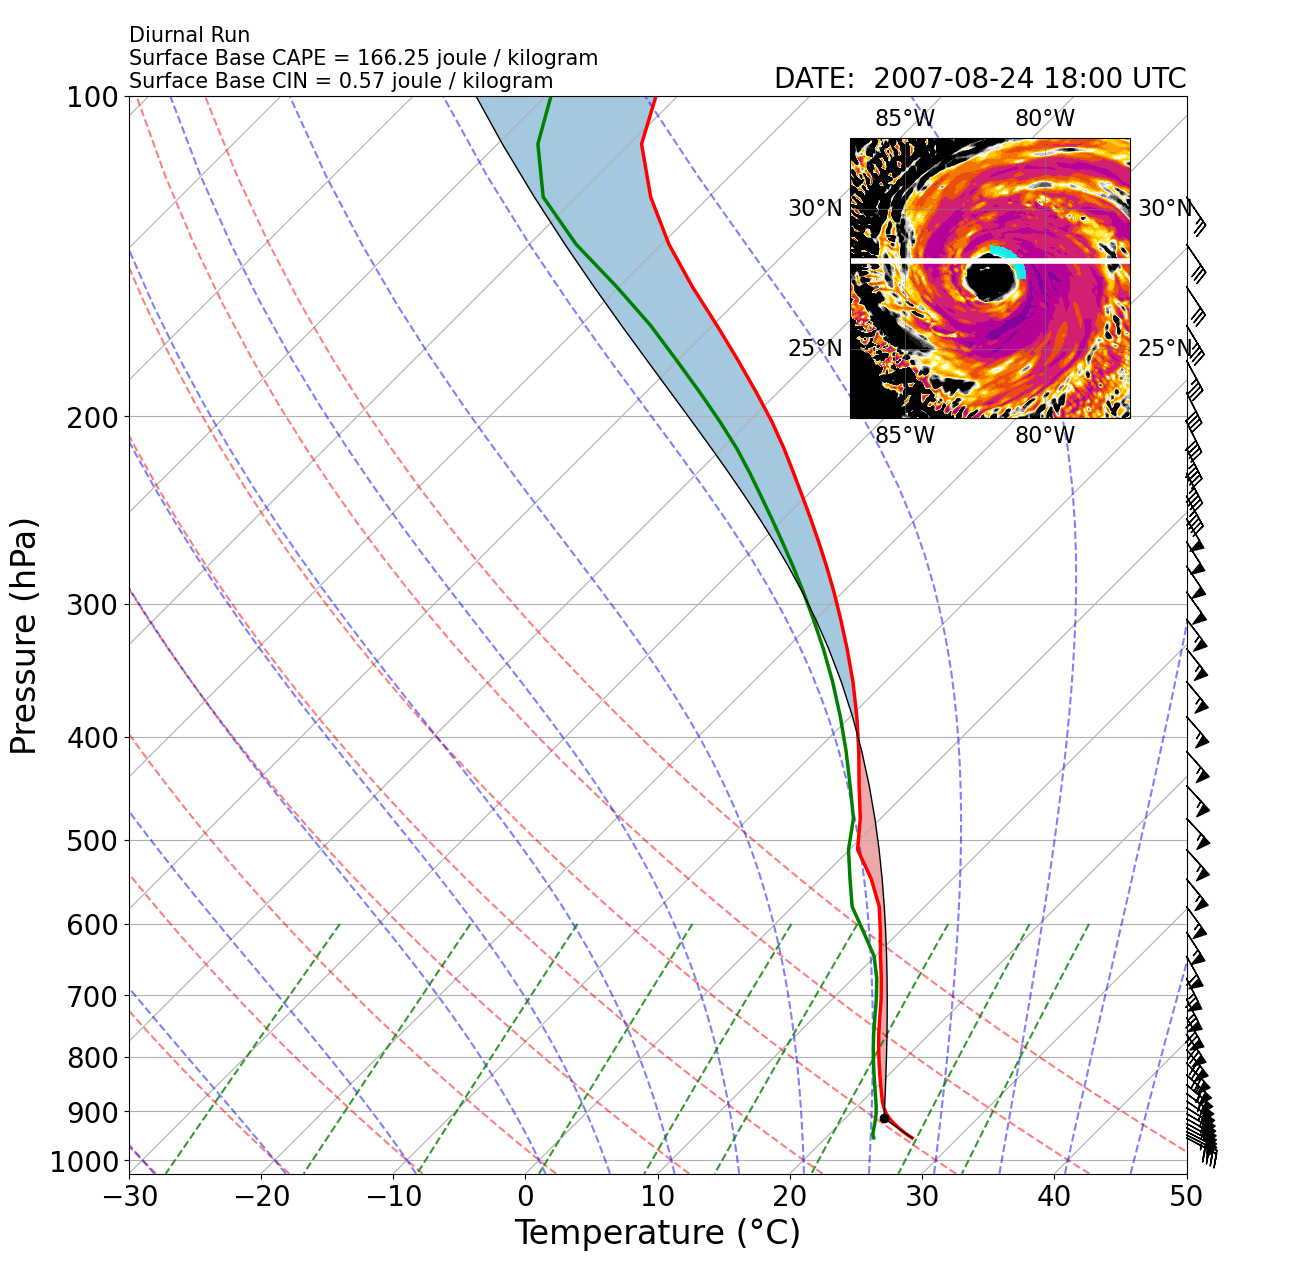

In [11]:
for item in range(54,55):
    ncfile = Dataset(datafiles_wrfout[item])
    wrf_out_data = xr.open_dataset(datafiles_wrfout[item])
    
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    
    #Get constant variables
    lat = getvar(ncfile, "XLAT")
    lon = getvar(ncfile, "XLONG")
    land = wrf_out_data['LANDMASK'][0,:,:].values
    ny, nx = lat.shape
    ###############################################################################################
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ##############################################################################################
    #IR brightness temperature
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_OLR_T = -273.15 + (wrf_out_OLR.values + 310)/2

    #for boundary layer stuff
    pblh = wrf_out_data['PBLH'][0,:,:]
    f    = wrf_out_data['F'][0,:,:]
    land = wrf_out_data['LANDMASK'][0,:,:]
    ##############################################################################################
    #Get pertinent values necessary for skew-T
    p1 = wrf.getvar(ncfile,"pressure",timeidx=0)               #Pressure
    T1 = wrf.getvar(ncfile,"tc",timeidx=0)                     #Temperature
    Td1 = wrf.getvar(ncfile,"td",timeidx=0)                    #Dewpoint
    u1 = wrf.getvar(ncfile,"ua",timeidx=0)                     #Zonal Winds
    v1 = wrf.getvar(ncfile,"va",timeidx=0)                     #Meridional Winds
    pot1 = wrf.getvar(ncfile,"th",timeidx=0)                   #potential Temperature
    height1 = wrf.getvar(ncfile,"height_agl",timeidx=0)        #Height above ground level for mass point

    print(np.shape(T1))
    ##############################################################################################
    #Now, we need to get the location of each sounding we are interested in!
    #First, we have to create lists
    ydist, xdist, tcdist, rlonfac, theta_ang = [np.zeros([ny,nx]) for _ in range(5)]
   
    #compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*np.cos(d2r*lat[:,:])
    ydist[:,:]   = (lat[:,:] - lat[ypos,xpos])*111000
    xdist[:,:]   = (lon[:,:] - (lon[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    
    #calculate angle
    theta_ang = np.arctan2(ydist, xdist)
    angles_deg = np.degrees(theta_ang) % 360
    
    #Pre-calculate cos and sin of theta_ang for use in vectorized calculations
    cos_theta = np.cos(theta_ang)
    sin_theta = np.sin(theta_ang)
    ##############################################################################################
    #Initialize subset arrays with zero values. Start with field variables, then diagnostics
    ugrd, vgrd, wind_abs = [np.zeros([ny,nx,n_zlevs]) for _ in range(3)]  #Range is just the number of variables specified to the left
    
    #Get variables 
    z_height = getvar(ncfile, "z")
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    
    for k in range(n_zlevs):
        clev = zlevs[k]
        uap = interplevel(ua, z_height, clev)
        vap = interplevel(va, z_height, clev)
        
        wind_abs[:,:,k] = np.sqrt(uap[:,:]**2 + vap[:,:]**2)
    ##############################################################################################
    #Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    binnum  = 63     #this lets us look at 250 kilometers away from the TC center
    binsize = 1
    dx      = 4000.   #Horizontal grid size of our domain
    
    xlabs = ['']*binnum

    windbin           = np.zeros([ny,nx])
    windzavg          = np.zeros([n_zlevs-1,int(binnum/binsize)])
    
    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        
        xlabs[j] = str(bincnt*12)
        for k in range (1, n_zlevs-1):
            windbin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), wind_abs[:,:,k], np.nan)
            windzavg[k,bincnt] = np.nanmean(windbin[:,:])
    ##############################################################################################
    #Flatten the windzavg array to find the maximum value across all levels and bins
    flat_index = np.nanargmax(windzavg)

    #Convert the flat index back to a 2D index (level, bin) to find the bin and level where the max occurs
    max_level, max_bin = np.unravel_index(flat_index, windzavg.shape)

    #Calculate the corresponding radius (in kilometers)
    max_wind_radius = max_bin * binsize * dx / 1000.  # Convert meters to kilometers

    #Print the results
    print(f"The maximum windzavg occurs at level {max_level} and radius {max_wind_radius} km")
    ##############################################################################################
    #Cool, we now know where the radius of maximim winds is, sooooo, we are going to use that as the lower bound of 
    #our area average sounding, outer bound will be 20km out of that!

    inner_radii = max_wind_radius + 20 #units in km
    outer_radii = max_wind_radius + 50 #units in km again!
    ##############################################################################################
    #lets first just look at the NE quadrant, so we are gonna look for TC dis that are: inner_radii < tdist[:,:,:] < outer_radii, &
    #0 <= angles_deg < 90, so we will only consider arrays

    mask = (tcdist >= inner_radii * 1000) & (tcdist <= outer_radii * 1000) & (angles_deg >= 0) & (angles_deg < 90)

    #Assuming your data arrays are xarray DataArray objects with shape (levels, lat, lon)
    n_levels = T1.shape[0]
    
    #Initialize lists to store the means at each vertical level
    T1_means = []
    p1_means = []
    Td1_means = []
    u1_means = []
    v1_means = []
    pot1_means = []
    height1_means = []
    
    for level in range(n_levels):
        #Apply the mask using the xarray where method
        T1_masked = T1[level].where(mask)
        p1_masked = p1[level].where(mask)
        Td1_masked = Td1[level].where(mask)
        u1_masked = u1[level].where(mask)
        v1_masked = v1[level].where(mask)
        pot1_masked = pot1[level].where(mask)
        height1_masked = height1[level].where(mask)
    
        #Calculate the nanmean for each masked DataArray
        T1_means.append(T1_masked.mean().item())  # .item() converts xarray scalar to Python float
        p1_means.append(p1_masked.mean().item())
        Td1_means.append(Td1_masked.mean().item())
        u1_means.append(u1_masked.mean().item())
        v1_means.append(v1_masked.mean().item())
        pot1_means.append(pot1_masked.mean().item())
        height1_means.append(height1_masked.mean().item())
    
    #Convert lists to arrays if needed
    T1_means = np.array(T1_means)
    p1_means = np.array(p1_means)
    Td1_means = np.array(Td1_means)
    u1_means = np.array(u1_means)
    v1_means = np.array(v1_means)
    pot1_means = np.array(pot1_means)
    height1_means = np.array(height1_means)

    #Assign Units
    p1_means = p1_means * units.hPa   #Assuming pressure in hPa
    T1_means = T1_means * units.degC  #Assuming temperature in degrees Celsius
    Td1_means = Td1_means * units.degC  #Assuming dewpoint in degrees Celsius
    u1_means = u1_means * units('m/s')
    v1_means = v1_means * units('m/s')

    ##############################################################################################
    #MetPy skew-T plotting
    fig = plt.figure(figsize = (14,14))
    skew = SkewT(fig, rotation = 45)
    ax1 = skew
    ax1.plot(p1_means, T1_means, 'r', linewidth = 2.5)
    ax1.plot(p1_means, Td1_means, 'g', linewidth = 2.5)
    
    #Specify Range Below for your plot
    ax1.ax.set_ylim(1030,100)
    ax1.ax.set_xlim(-30,50)
    
    #Calculate LCL and plot
    lcl_pressure, lcl_temperature = mpcalc.lcl(p1_means[0], T1_means[0], Td1_means[0])
    ax1.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    #Calculate parcel profile
    prof = mpcalc.parcel_profile(p1_means, T1_means[0], Td1_means[0])
    prof_celsius = prof.to('degC')  # Convert to Celsius
    
    #Plot the parcel profile
    ax1.plot(p1_means, prof_celsius, 'k', linewidth=1)
    
    #Shade CIN and CAPE areas
    ax1.shade_cin(p1_means, T1_means, prof_celsius) 
    ax1.shade_cape(p1_means, T1_means, prof_celsius)
    
    #Calculate surface-based CAPE and CIN
    cape_cin = mpcalc.cape_cin(p1_means, T1_means, Td1_means, prof)
    
    #Plot Wind Barbs
    ax1.plot_barbs(p1_means[:-5].m, u1_means[:-5].m, v1_means[:-5].m)
    
    #Plot additional lines on Skew-T
    ax1.plot_dry_adiabats()
    ax1.plot_moist_adiabats()
    ax1.plot_mixing_lines()
    
    #Set labels
    ax1.ax.set_xlabel("Temperature (°C)", fontsize = 24)
    ax1.ax.set_ylabel("Pressure (hPa)", fontsize = 24)

    #Set tick size using the underlying Axes object
    ax1.ax.tick_params(axis='both', which='major', labelsize=20)
    ax1.ax.tick_params(axis='both', which='minor', labelsize=20)

    plt.title(f'DATE: '+' '+titletime+' UTC', loc = 'right', fontsize = 20)
    plt.title(f'Diurnal Run\nSurface Base CAPE = {cape_cin[0]:.2f}\nSurface Base CIN = {-cape_cin[1]:.2f}', loc = 'left', fontsize = 15)
    ##############################################################################################
    #Next for valdiation purposes, show the approximate area of the sounding via the code above
    ax2 = fig.add_axes([0.65, 0.65, 0.2, 0.2], projection=ccrs.PlateCarree())  #Specify the location
    #ax2 = fig.add_axes([0.2, 0.4, 0.15, 0.15], projection=ccrs.PlateCarree())  #Specify the location
    tclon5a=5*(int(tc_lon/5)-1)
    tclon5b=5*(int(tc_lon/5))
    tclat5a=5*(int(tc_lat/5)-1)
    tclat5b=5*(int(tc_lat/5))
       
    ax2.set_extent([tc_lon-5, tc_lon+5, tc_lat-5, tc_lat+5],ccrs.PlateCarree()) #Constrain FOV of plot
    gl = ax2.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a-10, tclon5a-5, tclon5a, tclon5b, tclon5b+5, tclon5b+10])
    gl.ylocator = mticker.FixedLocator([tclat5a-10, tclat5a-5, tclat5a, tclat5b, tclat5b+5, tclat5b+10])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(gl.xformatter)
    ax2.yaxis.set_major_formatter(gl.yformatter)

    #Plot for ax2
    ax2.contourf(wrf_out_data['XLONG'][0,:,:].values, wrf_out_data['XLAT'][0,:,:].values, wrf_out_OLR_T,
            origin = 'lower', cmap = newcmp, levels = np.arange(-80, 5, 5), alpha = 1, extend ='both')

    land_contour = ax2.contour(lon,lat,land, 
                             colors='white', 
                             levels=np.arange(0, 2, 1),
                             linewidths=4)

    # Now, add the shaded region within ax2
    ax2.contourf(lon, lat, mask, levels=[0.5, 1], colors=['cyan'], alpha=.9, transform=ccrs.PlateCarree())  # Shading the masked area

    # #Save Figure now:
    output_path = f'/glade/work/cmasiello/python_scripts/Diurnal_Runs/Area_Average_Sounding/other/{filetime}.png'
    
    plt.savefig(output_path, bbox_inches='tight')
                
    plt.show()
    plt.close()

In [ ]:
from PIL import Image, ImageSequence

# Load all images
all_imgs = sorted(glob.glob("/glade/work/cmasiello/python_scripts/Diurnal_Runs/Area_Average_Sounding/other/*.png"))
images = [Image.open(img) for img in all_imgs]

# Save the images as a GIF
images[0].save('/glade/work/cmasiello/python_scripts/Diurnal_Runs/Area_Average_Sounding/other/Area_Average_Sounding.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)